## Dataset setup and preprocessing

In [ ]:
import time
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
import pandas as pd #taking long to load here
import seaborn as sns
import itertools
import copy,re, pdb, logging
from sklearn import linear_model
from collections import defaultdict

modules_to_import = [
    ('numpy', 'np'),
    ('scipy.stats', 'stats'),
    ('scipy.optimize', 'optimize'),
    ('matplotlib.pyplot', 'plt'),
    ('pandas', 'pd'),
    ('seaborn', 'sns'),
    ('itertools', 'itertools'),
    ('copy', 'copy'),
    ('re', 're'),
    ('pdb', 'pdb'),
    ('logging', 'logging'),
    ('sklearn.linear_model', 'linear_model'),
]

for module, alias in modules_to_import:
    start_time = time.time()
    exec(f"import {module} as {alias}")
    end_time = time.time()
    print(f"{module} imported in {end_time - start_time:.4f} seconds")


logging.getLogger().handlers.clear()

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        #logging.FileHandler(log_filename),
        logging.StreamHandler()
    ]
)


In [ ]:
#Feb 2025 dataset

#path 
path="/Users/iyngkarrankumar/Documents/GovAI WF/EUAIA_thresholds_project/data/notable_ai_models_24_02_2025.csv"

df = pd.read_csv(path)
df = df[~df["Notability criteria"].isna()]

df["compute"] = df["Training compute (FLOP)"]
df["date"] = pd.to_datetime(df["Publication date"])
df["year"] = pd.to_datetime(df["date"]).dt.year
df["model"] = df["Model"]
df["cost"] = df["Training compute cost (2023 USD)"]
df["cost"] = df["cost"].fillna("$0")  # Handle NaN values
df["cost"] = df["cost"].astype(str)  # Convert to string
df["cost"] = df["cost"].str.replace(",", "").str.replace("$", "").astype(float)
df = df[["model", "compute", "date", "cost","year"]]

# Models to remove
to_remove = ["AlphaGo Zero", "AlphaZero"]
df = df[~df["model"].isin(to_remove)]



# Print stats for full dataset
logging.info("=== Full Dataset ===")
logging.info("Most recent date: %s", df["date"].max())
logging.debug("Datapoints per year:")
for year in range(2017, 2025):
    count = len(df[df["year"] == year])
    logging.debug("%d: %d", year, count)

total_compute_2024 = df[df['year'] == 2024]['compute'].sum()
largest_model_2024 = df[df['year'] == 2024]['compute'].max()

max_compute_idx = df['compute'].idxmax()
logging.info("Largest compute value: %.2e (%s)", df.loc[max_compute_idx, 'compute'], df.loc[max_compute_idx, 'model'])
# Create dataset without specified years
years_to_exclude = [2025]  # List of years to exclude
df_filtered = df[~df["year"].isin(years_to_exclude)].copy()

logging.info("\n\n=== Dataset excluding years %s ===", years_to_exclude)
logging.info("Most recent date: %s", df_filtered["date"].max())

max_compute_idx = df_filtered['compute'].idxmax()
logging.info("Largest compute value: %.2e (%s)", df_filtered.loc[max_compute_idx, 'compute'], df_filtered.loc[max_compute_idx, 'model'])

df = df_filtered

# Report number of entries before removing NaN
logging.info("\n\n Number of entries before removing rows with compute=NaN: %d", len(df))

# Remove rows with NaN in compute column
df = df.dropna(subset=['compute'])

# Report number of entries after removing rows with compute=NaN
logging.info("Number of entries after removing rows with compute=NaN: %d", len(df))

logging.info("\nDatapoints per year after removing rows with compute=NaN:")
for year in range(2017, df.year.max()+1):
    count = len(df[df["year"] == year])
    logging.info("%d: %d", year, count)

# Get largest models in 2020 and 2021 and 2022
if 0: 
    for year in [2020, 2021, 2022]:
        year_data = df[df['year'] == year]
        max_compute_idx = year_data['compute'].idxmax()
        logging.info(f"\nLargest model in {year}:")
        logging.info(f"Model: {year_data.loc[max_compute_idx, 'model']}")
        logging.info(f"Date: {year_data.loc[max_compute_idx, 'date']}")
        logging.info(f"Compute: {year_data.loc[max_compute_idx, 'compute']:.2e}")


# Plot distribution of models 2020-2023
# Plot models from 2020-2023
df_plot = df[(df['year'] >= 2017) & (df['year'] <= 2025)]
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='date', y='compute', marker='x', hue='year', 
                alpha=1, palette='deep', s=100)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.title('Model Training Compute (2017-2024)', pad=15)
plt.xlabel('Date', labelpad=10)
plt.ylabel('Compute (FLOP)', labelpad=10)
plt.grid(alpha=0.5)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
#LMS and SMS
years=np.arange(2017,2025)
# Get total compute, smallest and largest models for each year
for year in years:
    year_data = df[df['year'] == year]
    if not year_data.empty:
        total_compute = year_data['compute'].sum()
        min_compute = year_data['compute'].min()
        max_compute = year_data['compute'].max()
        
        print(f"\nYear {year}:")
        print(f"Total compute: {total_compute:.2e}")
        print(f"Smallest/Total ratio: {min_compute/total_compute}")
        print(f"Largest/Total ratio: {max_compute/total_compute:.3f}")


In [ ]:
##FIT YEARS PLOTS - decide which years for fit years
min_absl_year=2017

# Analyze data year by year
# Calculate number of years for subplot layout
n_years = df.year.max() - min_absl_year + 1
n_cols = 3
n_rows = (n_years + n_cols - 1) // n_cols  # Ceiling division to handle non-divisible cases
nrows,ncols=3,2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))
axes = axes.flatten()  # Flatten to make indexing easier
fig.suptitle('Distribution of Model Compute by Year')

year_data_dict = {}

# Second pass to create actual subplots with consistent y-axis
for i, year in enumerate(range(min_absl_year, df.year.max()+1)):
    year_data = df[df['year'] == year]
    
    if not year_data.empty:
        # Find largest model that year
        max_compute_idx = year_data['compute'].idxmax()
        max_model = year_data.loc[max_compute_idx, 'model']
        max_compute = year_data.loc[max_compute_idx, 'compute']
        
        # Calculate total compute for the year
        total_compute = year_data['compute'].sum()
        n_datapoints = len(year_data)
        
        year_data_dict[year] = {
            'n_datapoints': n_datapoints,
            'largest_model': max_model,
            'max_compute': max_compute,
            'total_compute': total_compute,
            'LMS': max_compute/total_compute
        }
        
        # Create KDE plot for this year
        sns.kdeplot(data=np.log10(year_data['compute'].values), ax=axes[i])
        axes[i].set_title(f'Year {year}')
        axes[i].set_ylim(0, 0.6)
        axes[i].set_xlim(15,30)
        axes[i].grid(True, alpha=0.3)
        # Add text annotation for number of datapoints
        axes[i].text(0.05, 0.95, f'n={n_datapoints}', 
                    transform=axes[i].transAxes,
                    verticalalignment='top',
                    fontsize=15)

plt.xlabel('Log10(Compute) (FLOP)')
plt.tight_layout()


In [ ]:
#generate basic scatterplot
if 1:
    fig = sns.scatterplot(data=df[df['date']>'2010-01-01'], x='date',y='compute')
    fig.set(yscale='log')
    plt.grid(alpha=0.5)

    # Add line of best fit for historical data
    historical_data = df[df['date']>'2010-01-01']
    x = historical_data['date'].astype(np.int64) // 10**9  # Convert to unix timestamp
    y = historical_data['compute']
    z = np.polyfit(x, np.log(y), 1)
    p = np.poly1d(z)
    plt.plot(historical_data['date'], np.exp(p(x)), 'b--', alpha=0.8)

    future_dates = pd.date_range(start=f'{df.year.max()+1}-01-01', end='2029-12-31', periods=200)
    base = 1e25  # Starting point based on 2024 level
    noise = np.random.normal(0, 10, len(future_dates))
    years_from_2025 = (future_dates.year - (df.year.max()+1))

    growth_rate = 3.0  # Exponential growth rate
    future_compute = base * np.exp(growth_rate * years_from_2025) * (1 + noise)
    plt.scatter(future_dates, future_compute, alpha=0.3, color='red', label='Scenario A')

    growth_rate = 0.4
    future_compute = base * np.exp(growth_rate * years_from_2025) * (1 + noise)
    plt.scatter(future_dates, future_compute, alpha=0.3, color='green', label='Scenario B')

    growth_rate = 5.0  # Higher growth rate than Scenario A
    future_compute = base * np.exp(growth_rate * years_from_2025) * (1 + noise)
    plt.scatter(future_dates, future_compute, alpha=0.3, color='blue', label='Scenario C')

    plt.legend()
    plt.xlim([pd.Timestamp('2020-01-01'),pd.Timestamp('2030-01-01')])

    for exp in range(25,31):
        plt.axhline(y=10**exp,color='gray',linestyle='--',alpha=0.6)



## Utils + global params

In [5]:
#util funcs cell
def norm_exp_func(x,a,b,k):
    norm_factor=(1/k)*(np.exp(k*b)-np.exp(k*a))
    return (1/norm_factor)*np.exp(k*x)

def sample_from_exp_dist(a,b,k,spacing='linear'):
    x=np.linspace(a,b,10000) #might need to change this to logspace
    dx=x[1]-x[0] #differnt if logspace
    pdf=norm_exp_func(x,a,b,k=k)
    assert(round(sum(pdf*dx),2)==1), print(sum(pdf*dx)) #sanity check on probability dist
    prob_dist=pdf*dx
    prob_dist=prob_dist/np.sum(prob_dist) #ensure that sums exactly to 1 for use with np.random.choice

    return np.random.choice(x,p=prob_dist)


def decimal_year_to_date(decimal_year):
    if isinstance(decimal_year, pd.Series):
        return decimal_year.apply(lambda x: decimal_year_to_date(x))
    if isinstance(decimal_year, (list, np.ndarray)):
        return [decimal_year_to_date(x) for x in decimal_year]
    year = int(decimal_year)
    remainder = decimal_year-year
    days_in_year = 366 if pd.Timestamp(year,1,1).is_leap_year else 365
    days = int(remainder*days_in_year)
    return pd.Timestamp(year,1,1)+pd.Timedelta(days=days)


def alloc_ratio_to_alloc(alloc_ratio):
    #note - assumes alloc_rati = train/inf
    alloc_ratio=np.array(alloc_ratio)
    train_alloc=alloc_ratio/(1+alloc_ratio)
    inference_alloc=1-train_alloc
    return train_alloc, inference_alloc

def round_dates(dates, freq):
    #from Claude; unsure how this works
    if freq == '6M':
        return dates.map(lambda d: d.replace(day=1) + pd.offsets.MonthEnd(6 - (d.month - 1) % 6))
    elif freq == '3M':
        return dates.map(lambda d: d.replace(day=1) + pd.offsets.MonthEnd(3 - (d.month - 1) % 3))
    elif freq == '1M':
        return dates.map(lambda d: d.replace(day=1) + pd.offsets.MonthEnd(1))
    elif freq == '1Y':
        return dates.map(lambda d: d.replace(month=1, day=1) + pd.offsets.YearEnd())
    else:
        raise ValueError("Unsupported frequency")

def truncated_normal(mean,std_dev,min_lms=None,max_lms=None,size=1):
    if min_lms is None: min_lms=mean-3*std_dev
    if max_lms is None: max_lms=mean+3*std_dev
    samples = np.random.normal(mean, std_dev, size)
    return np.clip(samples, min_lms, max_lms) 


n_simulations = 100 #for bootstrappng, sampling parameters etc. 

## Training compute spending extrapolation

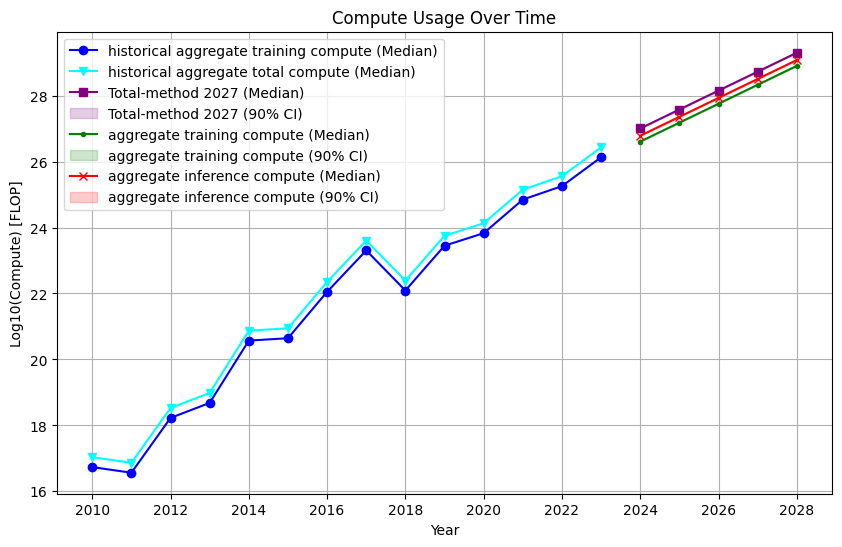

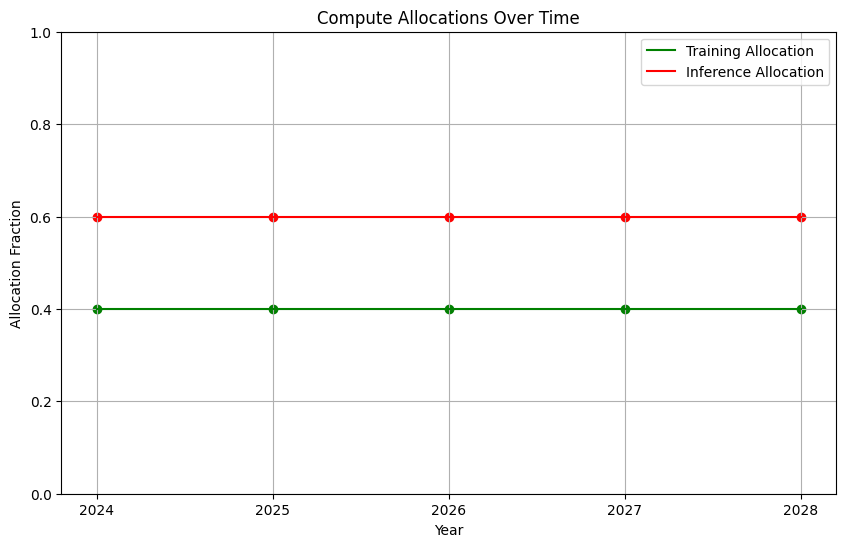

In [6]:
#total AI relevant compute extrapolations

fit_years = np.arange(2017,2024)
pred_years = np.arange(fit_years.max()+1,2029)
all_years = np.concatenate([fit_years,pred_years])

### PARAMETERS 
#extrap
AI2027_EXTRAP=True
method_choice="method 2027" #['linear extrapolation', 'method 2027']

hist_alloc=1/1
hist_alloc_multiplier=1+(1/hist_alloc)
FIXED_ALLOCATION=True
fixed_alloc=40/60
DYNAMIC_ALLOCATION=False #inference scaling continues improving
assert(FIXED_ALLOCATION+DYNAMIC_ALLOCATION)==1
pred_alloc_dict = {
        2024: 40/60,
        2025: 30/70,
        2026: 30/70,
        2027: 20/80,
        2028: 20/80,
    }

g_global_AI_compute_mean=2.25
g_AI_workload_share_mean=1.5 #assuming AI_compute_usage/AI_compute_capacity = const - 3.0 gets the two superposed!
g_total = g_global_AI_compute_mean + g_AI_workload_share_mean
g_stdev=0.5 #get more reasonable values by fixing rather than computing from historical data

###DATA STRUCTURE INIT
LOG_AGGREGATE_COMPUTE_DATA={}

###PLOT
PLOT=True


for sim in range(n_simulations):
    LOG_AGGREGATE_COMPUTE_DATA[sim] = {}

    year_grouped_df=df.groupby(df['date'][df['date']>'2010-01-01'].dt.year)
    aggregate_compute=year_grouped_df['compute'].sum()
    log_aggregate_compute=np.log10(aggregate_compute)

    recent_years = log_aggregate_compute[log_aggregate_compute.index.isin(fit_years)]
    recent_log_compute_dict = {int(k): v for k, v in recent_years.items()}


    if 1: #do historical data
        LOG_AGGREGATE_COMPUTE_DATA[sim]['historical aggregate training compute'] = {int(k): v for k, v in log_aggregate_compute.items()}
        LOG_AGGREGATE_COMPUTE_DATA[sim]['historical aggregate total compute'] = {int(k): v+np.log10(hist_alloc_multiplier) for k, v in log_aggregate_compute.items()}

    if AI2027_EXTRAP:
        previous_year_training_usage = 10**log_aggregate_compute.get(fit_years[-1])
        total_usage_previous_year = hist_alloc_multiplier * previous_year_training_usage

        AI_compute_usage={}
        sim_noise_term=np.random.normal(0,g_stdev) #set noise term for each sim 
        for idx,year in enumerate(pred_years):
            AI_compute_usage[year] = total_usage_previous_year * (g_total+sim_noise_term) ** (idx + 1)

        log_aggregate_compute_predictions_dict = {year: np.log10(compute) for year, compute in AI_compute_usage.items()}
        LOG_AGGREGATE_COMPUTE_DATA[sim]['Total-method 2027'] = log_aggregate_compute_predictions_dict


    #do allocations
    if 1: 
        if FIXED_ALLOCATION:
            train_alloc,inference_alloc=alloc_ratio_to_alloc(alloc_ratio=fixed_alloc)
            LOG_AGGREGATE_COMPUTE_DATA[sim]['aggregate training compute'] = {year: val + np.log10(train_alloc) for year, val in LOG_AGGREGATE_COMPUTE_DATA[sim][f"Total-{method_choice}"].items()}
            LOG_AGGREGATE_COMPUTE_DATA[sim]['aggregate inference compute'] = {year: val + np.log10(inference_alloc) for year, val in LOG_AGGREGATE_COMPUTE_DATA[sim][f"Total-{method_choice}"].items()}

        if DYNAMIC_ALLOCATION:
            train_alloc_dict = {}
            inference_alloc_dict = {}

            for year, val in LOG_AGGREGATE_COMPUTE_DATA[sim][f'Total-{method_choice}'].items():
                alloc_ratio=pred_alloc_dict.get(year,1.0)
                train_alloc, inference_alloc = alloc_ratio_to_alloc(alloc_ratio=alloc_ratio)
                train_alloc_dict[year] = val + np.log10(train_alloc)
                inference_alloc_dict[year] = val + np.log10(inference_alloc)

            LOG_AGGREGATE_COMPUTE_DATA[sim]['aggregate training compute'] = train_alloc_dict
            LOG_AGGREGATE_COMPUTE_DATA[sim]['aggregate inference compute'] = inference_alloc_dict


if PLOT:
    plt.figure(figsize=(10, 6))

    # Plot extrapolations for each method
    colors = {
        'historical aggregate training compute': 'blue',
        'historical aggregate total compute': 'cyan',
        'Total-method 2027': 'purple',
        'aggregate training compute': 'green',
        'aggregate inference compute': 'red',
    }
    markers = {
        'historical aggregate training compute': 'o',
        'historical aggregate total compute': 'v',
        'Total-method 2027': 's',
        'aggregate training compute': '.',
        'aggregate inference compute': 'x',
    }

    for method in colors.keys():
        all_sim_values = defaultdict(list)
        
        for sim in range(n_simulations):
            predictions = LOG_AGGREGATE_COMPUTE_DATA[sim].get(method, {})
            for year, value in predictions.items() :
                all_sim_values[year].append(value)
        
        years = sorted(all_sim_values.keys())
        medians = [np.median(all_sim_values[year]) for year in years]
        lower_bounds = [np.percentile(all_sim_values[year], 5) for year in years]
        upper_bounds = [np.percentile(all_sim_values[year], 95) for year in years]

        plt.plot(years, medians, label=f'{method} (Median)', color=colors[method], marker=markers[method])
        if "historical" not in method:
            plt.fill_between(years, lower_bounds, upper_bounds, color=colors[method], alpha=0.2, label=f'{method} (90% CI)')

    plt.xlabel('Year')
    plt.ylabel('Log10(Compute) [FLOP]')
    plt.title(f'Compute Usage Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(min(log_aggregate_compute.index), 2030, 2))

    # Plot compute allocations
    plt.figure(figsize=(10, 6))

    years = sorted(pred_alloc_dict.keys())
    alloc_ratios = [pred_alloc_dict[y] for y in years]

    train_allocs = []
    inference_allocs = []
    if FIXED_ALLOCATION:
        train_allocs, inference_allocs = alloc_ratio_to_alloc(np.ones(years.__len__()) * fixed_alloc)
    if DYNAMIC_ALLOCATION:
        train_allocs, inference_allocs = alloc_ratio_to_alloc(np.array(list(pred_alloc_dict.values())))

    plt.plot(years, train_allocs, 'g-', label='Training Allocation')
    plt.plot(years, inference_allocs, 'r-', label='Inference Allocation')
    plt.scatter(years, train_allocs, color='green', marker='o')
    plt.scatter(years, inference_allocs, color='red', marker='o')
    plt.ylim(0, 1)

    plt.xlabel('Year')
    plt.ylabel('Allocation Fraction')
    plt.title('Compute Allocations Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(years)


## Fit allocations for fit years

In [7]:
#get compute_alloc fits
fit_years=fit_years
pred_years = pred_years

FIT_DATA={year:None for year in fit_years}
constraint_point=(1,1)
filter_thresholds=1e-20 #ignore models smaller than this


logging.info('Fitting f_M coefficients')

for idx,year in enumerate(fit_years):
    total_compute=aggregate_compute[aggregate_compute.index==year].values
    datapoints_year=df[df['date'].dt.year==year]['compute']
    mean_log_compute=np.log10(datapoints_year).mean()
    largest_model=datapoints_year.max()
    smallest_model=datapoints_year.min()
    norm_factor_total=total_compute[0]

    #ms
    sorted_computes=np.sort(datapoints_year)
    norm_sorted_computes=sorted_computes/largest_model
    
    #cum_alloc
    cumsum=np.cumsum(sorted_computes)
    norm_cum_alloc=cumsum/norm_factor_total

    #catg_alloc (derived from cum_alloc)
    norm_catg_alloc = np.diff(norm_cum_alloc)
    residual_catg_alloc = 1-np.sum(norm_catg_alloc)
    norm_catg_alloc = np.concatenate((np.array([residual_catg_alloc]),norm_catg_alloc))

    #store data 
    FIT_DATA[year]={
    'compute':sorted_computes,
    'cumulative_sum':cumsum,
    'norm_factor_total':norm_factor_total,
    'largest_model':largest_model,
    'norm_smallest_model':smallest_model/largest_model,
    'norm_cum_alloc fits':None,
    'norm_catg_alloc fits':None,
            }
    
    #fit data
    X = np.log10(norm_sorted_computes).reshape(-1, 1)
    y = np.log10(norm_cum_alloc)
    X_trans,y_trans=X-constraint_point[0],y-constraint_point[1]
    reg_cum_alloc = linear_model.LinearRegression(fit_intercept=False).fit(X_trans, y_trans) #forcing X-a,y-b to go through (0,0) means X,y goes through (a,b)
    FIT_DATA[year]['cum_alloc_fits'] = [reg_cum_alloc.coef_[0], reg_cum_alloc.intercept_]


    X,y = np.log10(norm_sorted_computes).reshape(-1,1),np.log10(norm_catg_alloc).reshape(-1,1)
    reg_catg_alloc = linear_model.LinearRegression(fit_intercept=True).fit(X,y) #we claim that there is a linear relationship between log(norm_computes) and log(catg_alloc)
    FIT_DATA[year]['catg_alloc_fits'] = [reg_catg_alloc.coef_[0][0], reg_catg_alloc.intercept_[0]]
    FIT_DATA[year]['norm_catg_alloc']=norm_catg_alloc

if 0:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
    axes = [ax1, ax2, ax3, ax4]
    
    for i, year in enumerate(fit_years):
        if year in FIT_DATA:
            data = FIT_DATA[year]
            norm_sorted_computes = data['compute'] / data['largest_model']
            norm_catg_alloc = data['norm_catg_alloc']
            m, b = data['catg_alloc_fits']
            
            axes[i].scatter(norm_sorted_computes, norm_catg_alloc, marker='x', s=50, label=f'Data points')
            log_catg_alloc = m * np.log10(norm_sorted_computes) + b #the relationship in log space
            y_fit = 10**(log_catg_alloc)
            axes[i].plot(norm_sorted_computes, y_fit, label=f'Fit (m={m:.2f}, b={b:.2f})')

            # Create extrapolation points from smallest x value back to near 0
            min_x = np.min(data['compute'] / data['largest_model'])
            x_extrap = np.logspace(-10, np.log10(min_x), 100)
            log_catg_alloc = m * np.log10(x_extrap) + b
            y_extrap = 10**(log_catg_alloc)
            
            axes[i].plot(x_extrap, y_extrap, '--', alpha=0.5)
            
            axes[i].set_xlabel('Normalized Sorted Computes')
            axes[i].set_ylabel('Normalized Category Allocations')
            axes[i].set_title(f'Year {year}')
            axes[i].set_xscale('log')
            axes[i].set_yscale('log')
            axes[i].legend()
            axes[i].grid(True)

    plt.tight_layout()
    plt.show()
    

    # Log debug - Print cum_alloc_fits for all years
    logging.info("cum_alloc_fits for each year:")
    cum_alloc_coeffs = FIT_DATA[year]['cum_alloc_fits']
    catg_alloc_coeffs = FIT_DATA[year]['catg_alloc_fits']
    logging.info(f"Year {year}: cum_alloc_fits - slope={cum_alloc_coeffs[0]:.4f}, intercept={cum_alloc_coeffs[1]:.4f}")
    logging.info(f"Year {year}: catg_alloc_fits - slope={catg_alloc_coeffs[0]:.4f}, intercept={catg_alloc_coeffs[1]:.4f}")

2025-03-27 00:14:03 - INFO - Fitting f_M coefficients


## Generate compute samples

In [ ]:
##generate compute samples

np.random.seed(None) #no seeding
import logging


##allocation fits
ALLOC_FIT_TYPE='cumulative' #[cumulative, categorical]
POINT_CUM_ALLOC_PARAMS=False #takes mean of historical datas
DISTRIBUTION_CUM_ALLOC_PARAMS=True
grad_cum_alloc_min, grad_cum_alloc_max = 0.9, 1.10 #for setting up uncertainty modelling
assert(POINT_CUM_ALLOC_PARAMS+DISTRIBUTION_CUM_ALLOC_PARAMS)==1, "Only one of DEFAULT_CUM_ALLOC_PARAMS or CUSTOM_CUM_ALLOC_PARAMS can be True"

DEFAULT_CATG_ALLOC_PARAMS=True
CUSTOM_CATG_ALLOC_PARAMS=False
custom_catg_alloc_params = (1,-0.5)

assert(DEFAULT_CATG_ALLOC_PARAMS+CUSTOM_CATG_ALLOC_PARAMS)==1, "Only one of DEFAULT_CATG_ALLOC_PARAMS or CUSTOM_CATG_ALLOC_PARAMS can be True"

#IMPORTANT PARAMETER - largest model share
LMS_SAMPLING="uniform"
assert LMS_SAMPLING in ['gaussian', 'uniform']
largest_model_share_mean,lms_stddev,min_lms,max_lms=0.3, 0.1,0.10,0.50

#min m sampling
min_norm_m_min,min_norm_m_max = 1e-8, 1e-6 #wacky variable names

#n_catg setting (higher the better, up to a point where delta M gets too small)
n_catgs = 20

PLOT_KDES=False
PLOT_SCATTER=True


all_years=np.concatenate([fit_years, pred_years.astype(int).ravel()])
COMPUTE_SAMPLE_DATA = {sim: {int(year): {} for year in all_years} for sim in range(n_simulations)} #init data structure 

for sim in range(n_simulations):

    for year in all_years:
        #get total compute
        if year in fit_years:
            log_agg_training_compute = LOG_AGGREGATE_COMPUTE_DATA[sim]["historical aggregate training compute"][year]
        if year in pred_years:
            log_agg_training_compute = LOG_AGGREGATE_COMPUTE_DATA[sim]["aggregate training compute"][year]
        agg_training_compute = 10**log_agg_training_compute 

        #set largest model that year 
        if LMS_SAMPLING=='gaussian':
            norm_largest_model = truncated_normal(mean=largest_model_share_mean,std_dev=lms_stddev,min_lms=min_lms,max_lms=max_lms, size=1)[0]
        elif LMS_SAMPLING=='uniform':
            norm_largest_model = np.random.uniform(min_lms, max_lms)

        largest_model = norm_largest_model * agg_training_compute
        assert largest_model <= 0.5*agg_training_compute, print(f"Year: {year}, Largest Model: {largest_model}, Total Training Compute: {agg_training_compute}")

        #sample smallest model that year
        min_norm_m = 10**(np.random.uniform(np.log10(min_norm_m_min),np.log10(min_norm_m_max)))

        # model sizes (as fraction of largest_model)
        norm_ms = np.logspace(np.log10(min_norm_m), np.log10(1.0), num=n_catgs)
        log_norm_ms = np.log10(norm_ms)


        assert ALLOC_FIT_TYPE in ['cumulative','categorical']

        #generate compute bin allocations (catg_alloc)
        VALID_ALLOCATION=False
        while not VALID_ALLOCATION:
            if POINT_CUM_ALLOC_PARAMS:
                grad_cum_alloc = np.mean([FIT_DATA[year]['cum_alloc_fits'][0] for year in FIT_DATA.keys()])
                int_cum_alloc = np.mean([FIT_DATA[year]['cum_alloc_fits'][1] for year in FIT_DATA.keys()])
            elif DISTRIBUTION_CUM_ALLOC_PARAMS:
                grad_cum_alloc, int_cum_alloc = np.random.uniform(grad_cum_alloc_min,grad_cum_alloc_max), 0
            else:
                raise ValueError("Invalid choice of cumulative alloc params")

            log_cum_alloc = grad_cum_alloc*log_norm_ms + int_cum_alloc
            cum_alloc = 10**log_cum_alloc
            catg_alloc = np.diff(cum_alloc)
            sum_condition = abs(np.sum(catg_alloc) - 1) < 1e-5
            assert sum_condition, f"Sum of category allocations {np.sum(catg_alloc)} not equal to 1" #stop code if not equal to 1

            residual_catg_alloc = 1-np.sum(catg_alloc)
            catg_alloc = np.concatenate(([residual_catg_alloc],catg_alloc))

            absl_ms = norm_ms*largest_model
            absl_model_catgs = [(absl_ms[i], absl_ms[i+1]) for i in range(len(absl_ms) - 1)]
            absl_model_catgs = [(min_norm_m*largest_model,min_norm_m*largest_model)] + absl_model_catgs
            absl_allocs = catg_alloc * agg_training_compute
            alloc_ub_check_var = [ctg[-1] for ctg in absl_model_catgs] < absl_allocs
            alloc_ub_condition = np.all(alloc_ub_check_var) #ensure all allocs are above the ctg_ub
            #assert(alloc_ub_condition), print(f'{(~alloc_ub_check_var).sum()/len(alloc_ub_check_var)*100} of alloc-ctg pairs exceed ctg_ub')

            if alloc_ub_condition: 
                VALID_ALLOCATION=True
            else:
                VALID_ALLOCATION=False
                #print(f'{(~alloc_ub_check_var).sum()/len(alloc_ub_check_var)*100} of alloc-ctg pairs exceed ctg_ub')
                #print(f"Invalid allocation for year {year}, gradient: {grad_cum_alloc}")




        model_ctgs = [(norm_ms[i], norm_ms[i+1]) for i in range(len(norm_ms) - 1)]
        model_ctgs = [(min_norm_m,min_norm_m)] + model_ctgs #for first ctg bin - we sample just the smallest model
        ctgs_lbs, ctgs_ubs =[ctg[0] for ctg in model_ctgs], [ctg[-1] for ctg in model_ctgs] #useful vars

        bin_compute_allocs = catg_alloc * agg_training_compute  # array of how much compute allocated to each bin

        compute_samples_rand = []

        #draw samples
        for idx, (ctg, alloc) in enumerate(list(zip(model_ctgs, bin_compute_allocs))):
            if idx==0: continue
            

            # set initial bounds
            bounds = ctg
            norm_model_bin_lb, norm_model_bin_ub = float(bounds[0]), float(bounds[1])
            model_bin_lb, model_bin_ub = largest_model * norm_model_bin_lb, largest_model * norm_model_bin_ub  # normalising factor is total training compute
            assert alloc > model_bin_ub
            if alloc==0:  # skip bins which have no compute allocated to them - occurs when allocation gradient large 
                continue 

            
            #perform sampling 
            allocnorm_model_bin_lb, allocnorm_model_bin_ub = model_bin_lb / alloc, model_bin_ub / alloc  # this is purely just for sampling; no physical meaning
            running_tot = 0
            allocnormed_samples = []
            while running_tot < 1:
                # SAMPLE
                sample = np.random.uniform(allocnorm_model_bin_lb, allocnorm_model_bin_ub)
                sample = float(sample) if isinstance(sample, np.ndarray) else sample
                assert sample <= 1 #sample should be smaller than alloc OR equal to it


                # SUM CHECK
                if running_tot + sample > 1:
                    allocnormed_samples.append(1 - running_tot)
                    running_tot = 1
                else:
                    allocnormed_samples.append(sample)
                    running_tot += sample

            bin_samples = alloc*np.array(allocnormed_samples) # un-normalise
            compute_samples_rand = compute_samples_rand + (list(bin_samples)) #add to sample list

            #print(f"Number of samples drawn for model category: {len(allocnormed_samples)}")


        compute_samples_rand = [x for x in compute_samples_rand if x != 0]
        #print(f"Samples drawn for sim {sim}, year {year}: {len(compute_samples_rand)}")

        COMPUTE_SAMPLE_DATA[sim][year]['samples'] = compute_samples_rand
        COMPUTE_SAMPLE_DATA[sim][year]['date'] = [decimal_year_to_date(year + np.random.random()) for _ in compute_samples_rand]  # convert to standard pd datetime format
        COMPUTE_SAMPLE_DATA[sim][year]['largest model'] = largest_model


logging.debug("\nNumber of samples per year:")
for year in pred_years.ravel():
    logging.debug(f"{year}: {len(COMPUTE_SAMPLE_DATA[0][year]['samples'])} samples") #take first sim

        

if PLOT_KDES:
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    axes = axes.ravel()

    for idx, year in enumerate(pred_years):
        all_samples = [np.log10(COMPUTE_SAMPLE_DATA[sim][year]['samples']) for sim in range(n_simulations)]
        
        # Define a common set of x-points for KDE evaluation
        x_points = np.linspace(15, 30, 1000)
        
        # Evaluate KDE for each simulation
        from scipy.stats import gaussian_kde
        kde_values = [gaussian_kde(samples)(x_points) for samples in all_samples]
        
        # Calculate median and 90th percentile KDE values at each x-point
        median_kde = np.median(kde_values, axis=0)
        lower_bound_kde = np.percentile(kde_values, 5, axis=0)
        upper_bound_kde = np.percentile(kde_values, 95, axis=0)
        
        # Plot the median KDE
        axes[idx].plot(x_points, median_kde, label='Median KDE')
        
        # Fill between the 5th and 95th percentile KDE values
        axes[idx].fill_between(x_points, lower_bound_kde, upper_bound_kde, alpha=0.3, label='90% CI')
        
        axes[idx].set_title(f'Year {year}')
        axes[idx].set_xlabel('log compute (FLOPs)')
        axes[idx].set_ylabel('Density')
        axes[idx].grid(alpha=0.5)
        axes[idx].set_xlim([15, 30])
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

if PLOT_SCATTER:
    ylims = (14, 30)
    plt.figure(figsize=(12, 6))
    
    for year in all_years:
        if year in fit_years:
            sample_data = COMPUTE_SAMPLE_DATA[0][year]
            plt.scatter(sample_data['date'], np.log10(sample_data['samples']), alpha=0.2, color='blue', label='Retrodicted Samples' if year == fit_years[0] else "",marker='x')
        if year in pred_years:
            sample_data = COMPUTE_SAMPLE_DATA[0][year]
            plt.scatter(sample_data['date'], np.log10(sample_data['samples']), alpha=0.5, label='Projected Samples' if year == pred_years[0] else "", color='red')

    plt.scatter(df[df['year'].isin(fit_years)]['date'], np.log10(df[df['year'].isin(fit_years)]['compute']), alpha=1.0, label='Historical',marker='x')


    plt.xlabel('Year')
    plt.ylabel('Log Compute (FLOPs)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.ylim(ylims)
    plt.yticks(np.arange(ylims[0], ylims[1], 0.5))
    plt.show()


## Backtesting

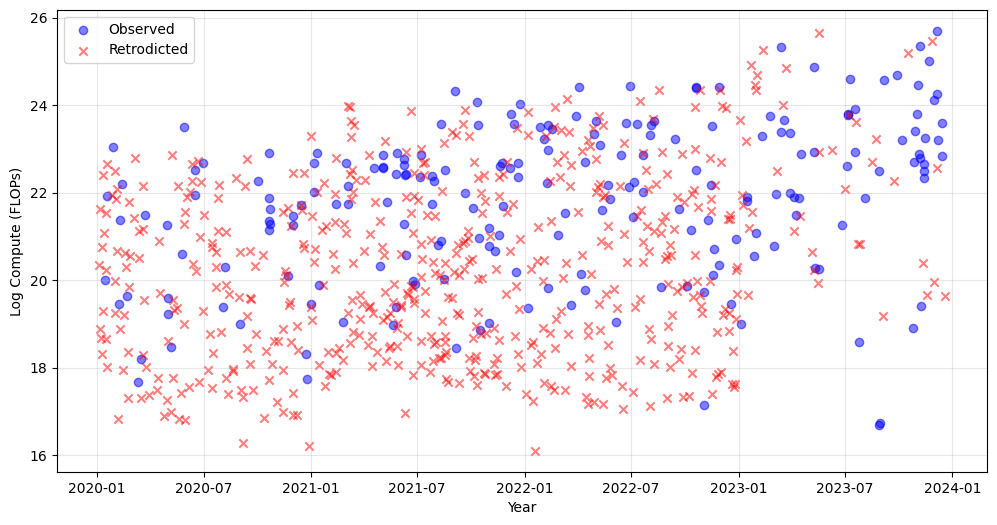

In [9]:
plt.figure(figsize=(12, 6))
sim_idx=0
# Scatter plot for observed data
for year in range(2020, 2024):
    observed_data = df[df['year'] == year]
    plt.scatter(observed_data['date'], np.log10(observed_data['compute']), alpha=0.5, label=f'Observed' if year==2020 else "", color='blue')

# Scatter plot for retrodicted data
for year in range(2020, 2024):
    retrodicted_data = COMPUTE_SAMPLE_DATA[sim_idx][year]
    plt.scatter(retrodicted_data['date'], np.log10(retrodicted_data['samples']), alpha=0.5, label=f'Retrodicted' if year==2020 else "", color='red', marker='x')

plt.xlabel('Year')
plt.ylabel('Log Compute (FLOPs)')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [10]:
retrodict_thresholds=[23,24,25]
threshold_widths = [0.5,1.0,1.5]  # List of threshold widths to analyze
period_freq = '3M'  # Can be changed to any frequency like '1Y', '3M', '4M', '6M'
thresholds = [25, 26, 27, 28, 29]
CI_percentiles=[10,50,90]

In [11]:
#backtesting the absolute thresholds

retrodict_years=fit_years

#observed
# Create DataFrame from observed counts
df_observed = pd.DataFrame.from_dict({threshold: {year: sum(df[df['year'] == year]['compute'] > 10**threshold)
                                                for year in retrodict_years}
                                    for threshold in retrodict_thresholds}, 
                                    orient='index')
df_observed.index = [f'{10**threshold:.2e}' for threshold in retrodict_thresholds]
df_observed.index.name = 'Threshold'

# Create retrodict counts dictionary
retrodict_counts = {year: {threshold: [] for threshold in retrodict_thresholds} for year in retrodict_years}

for sim, sim_data in COMPUTE_SAMPLE_DATA.items():
    for year, year_data in sim_data.items():
        if year in retrodict_years:
            for threshold in retrodict_thresholds:
                count = (sum(x >= 10**threshold for x in year_data['samples'])).astype(int)
                retrodict_counts[year][threshold].append(count)

# Calculate percentiles for each year and threshold

retrodict_percentile_counts = {year: {percentile: [] for percentile in CI_percentiles} for year in retrodict_years}
for year in retrodict_years:
    for threshold in retrodict_thresholds:
        for percentile in CI_percentiles:
            percentile_count = (np.percentile(retrodict_counts[year][threshold], percentile)).astype(int)
            retrodict_percentile_counts[year][percentile].append(percentile_count)

dfs_retrodict = {}
for percentile in CI_percentiles:
    dfs_retrodict[percentile] = pd.DataFrame(
        {year: retrodict_percentile_counts[year][percentile] for year in retrodict_years},
        index=[f'{10**t:.2e}' for t in retrodict_thresholds]
    )
    dfs_retrodict[percentile].index.name = 'Threshold'

# Take cumulative sum across years for both dataframes
df_observed_cumulative = df_observed.cumsum(axis=1)
dfs_retrodict_cumulative = {percentile: df.cumsum(axis=1) for percentile, df in dfs_retrodict.items()}


# Create dataframe with observed and retrodicted values for each percentile
combined_df = pd.DataFrame(index=df_observed_cumulative.index)

for year in df_observed_cumulative.columns:
    combined_df[year] = [f"{obs} ({','.join(str(x) for x in ret)})" for obs, ret in zip(
        df_observed_cumulative[year],
        zip(*[dfs_retrodict_cumulative[percentile][year] for percentile in CI_percentiles])
    )]

display(combined_df)
# Calculate the difference between observed and retrodicted values for each percentile
difference_df = pd.DataFrame(index=df_observed_cumulative.index)

for year in df_observed_cumulative.columns:
    differences = []
    for obs, *rets in zip(df_observed_cumulative[year], 
                         *[dfs_retrodict_cumulative[percentile][year] for percentile in CI_percentiles]):
        differences.append(f"{obs-rets[0]}, {obs-rets[1]}, {obs-rets[2]}")
    difference_df[year] = differences

display(difference_df)


,2020,2021,2022,2023
Threshold,,,,
1.00e+23,"2 (0,2,3)","9 (8,13,21)","29 (19,30,52)","54 (36,55,99)"
1.00e+24,"0 (0,0,0)","3 (0,2,3)","8 (4,7,10)","19 (14,21,33)"
1.00e+25,"0 (0,0,0)","0 (0,0,0)","0 (0,0,0)","4 (3,4,5)"


,2020,2021,2022,2023
Threshold,,,,
1.00e+23,"2, 0, -1","1, -4, -12","10, -1, -23","18, -1, -45"
1.00e+24,"0, 0, 0","3, 1, 0","4, 1, -2","5, -2, -14"
1.00e+25,"0, 0, 0","0, 0, 0","0, 0, 0","1, 0, -1"


In [12]:
## frontier counts

import warnings; warnings.filterwarnings('ignore')


# Group data into specified periods
df['period'] = round_dates(df['date'], period_freq)
df['log_compute'] = np.log10(df['compute'])

frontier_counts = {}

for year in fit_years:
    year_filtered_df = df[df['date'].dt.year == year]
    frontier_counts[year] = {}
    for width in threshold_widths:
        width_year_counts = 0
        for idx, period in enumerate(sorted(year_filtered_df['period'].unique())):
            largest_model = df[df['period'] < period]['compute'].max()  # get largest model before this period
            period_data = df[df.period == period]
            within_threshold_condition = ((np.log10(largest_model) - np.log10(period_data['compute'])) <= width) & ((np.log10(largest_model) - np.log10(period_data['compute'])) > 0)
            above_frontier_condition = period_data['compute'] > largest_model
            count = within_threshold_condition.sum() + above_frontier_condition.sum()
            width_year_counts += count
        frontier_counts[year][width] = width_year_counts

# Calculate frontier counts for each percentile
sample_frontier_counts = {year: {width: [] for width in threshold_widths} for year in fit_years}

for sim, sim_data in COMPUTE_SAMPLE_DATA.items():
    for year in fit_years:
        year_data = sim_data[year]
        year_data['period'] = round_dates(pd.to_datetime(year_data['date']), period_freq)
        year_data['log_compute'] = np.log10(year_data['samples'])
        
        for width in threshold_widths:
            width_year_counts = 0
            for period in sorted(year_data['period'].unique()):
                largest_model = max(np.concatenate([np.array(data['samples'])[np.array(data['date']) < period] for data in sim_data.values()]))
                period_sample_data = np.array(year_data['samples'])[year_data['period'] == period]
                within_threshold_condition = (np.log10(largest_model) - np.log10(period_sample_data) <= width) & (np.log10(largest_model) - np.log10(period_sample_data) > 0)
                above_frontier_condition = period_sample_data > largest_model
                width_year_counts += within_threshold_condition.sum() + above_frontier_condition.sum()
            sample_frontier_counts[year][width].append(width_year_counts)

# Calculate percentile counts for each year and width
percentile_frontier_counts = {year: {width: {percentile: [] for percentile in CI_percentiles} for width in threshold_widths} for year in fit_years}
for year in fit_years:
    for width in threshold_widths:
        for percentile in CI_percentiles:
            percentile_count = (np.percentile(sample_frontier_counts[year][width], percentile)).astype(int)
            percentile_frontier_counts[year][width][percentile] = percentile_count

# Create combined dataframe with observed and retrodicted values
combined_df = pd.DataFrame(index=threshold_widths)
combined_df.index.name = 'width'

for year in fit_years:
    combined_df[year] = [f"{frontier_counts[year][width]} ({','.join(str(percentile_frontier_counts[year][width][p]) for p in CI_percentiles)})" for width in threshold_widths]

display(combined_df)

# Calculate differences between observed and retrodicted values
difference_df = pd.DataFrame(index=threshold_widths)
difference_df.index.name = 'width'

for year in fit_years:
    differences = []
    for width in threshold_widths:
        obs = frontier_counts[year][width]
        rets = [percentile_frontier_counts[year][width][p] for p in CI_percentiles]
        differences.append(f"{obs-rets[0]}, {obs-rets[1]}, {obs-rets[2]}")
    difference_df[year] = differences

display(difference_df)



,2020,2021,2022,2023
width,,,,
0.5,"2 (2,4,12)","4 (2,4,11)","5 (1,5,10)","5 (2,4,10)"
1.0,"5 (5,8,25)","19 (5,9,22)","16 (5,9,25)","11 (5,9,20)"
1.5,"9 (8,13,37)","27 (8,13,33)","22 (8,15,37)","17 (8,14,29)"


,2020,2021,2022,2023
width,,,,
0.5,"0, -2, -10","2, 0, -7","4, 0, -5","3, 1, -5"
1.0,"0, -3, -20","14, 10, -3","11, 7, -9","6, 2, -9"
1.5,"1, -4, -28","19, 14, -6","14, 7, -15","9, 3, -12"


## Threshold counting

In [13]:
## regular counts

threshold_counts_all_simulations = {year: {threshold: [] for threshold in thresholds} for year in pred_years.astype(int).ravel()}

# Iterate over each simulation
for sim in range(len(COMPUTE_SAMPLE_DATA)):
    for year, samples in COMPUTE_SAMPLE_DATA[sim].items():
        if year in pred_years:
            for threshold in thresholds:
                count = sum(x >= 10**threshold for x in samples['samples'])
                threshold_counts_all_simulations[year][threshold].append(count)

# Calculate counts for each percentile in CI_percentiles
threshold_counts_summary = {year: [] for year in pred_years.astype(int).ravel()}
for year in pred_years.astype(int).ravel():
    for threshold in thresholds:
        counts = threshold_counts_all_simulations[year][threshold]
        percentile_counts = [np.percentile(counts, p) for p in CI_percentiles]
        threshold_counts_summary[year].append(f"{percentile_counts[1]:.0f} ({percentile_counts[0]:.0f}-{percentile_counts[2]:.0f})")

# Create DataFrames for each percentile
percentile_dfs = {}
for percentile in CI_percentiles:
    percentile_dfs[percentile] = pd.DataFrame(
        {year: [int(round(np.percentile(threshold_counts_all_simulations[year][threshold], percentile))) 
                for threshold in thresholds] 
         for year in pred_years.astype(int).ravel()},
        index=[f'>1e{t}' for t in thresholds]
    )

# Make cumulative across years
percentile_dfs_cumulative = {
    percentile: df.cumsum(axis=1) 
    for percentile, df in percentile_dfs.items()
}

# Combine into a single DataFrame
df_combined_cumulative = pd.DataFrame()
for year in percentile_dfs_cumulative[50].columns:
    for idx in percentile_dfs_cumulative[50].index:
        values = [str(percentile_dfs_cumulative[p].loc[idx, year]) for p in CI_percentiles]
        df_combined_cumulative.loc[idx, year] = ", ".join(values)
display(df_combined_cumulative)



,2024,2025,2026,2027,2028
>1e25,"7, 9, 13","18, 25, 44","32, 44, 81","50, 71, 134","73, 105, 195"
>1e26,"0, 0, 1","3, 5, 7","11, 15, 23","22, 32, 51","38, 55, 91"
>1e27,"0, 0, 0","0, 0, 0","0, 1, 2","5, 7, 10","14, 19, 30"
>1e28,"0, 0, 0","0, 0, 0","0, 0, 0","0, 0, 0","0, 3, 3"
>1e29,"0, 0, 0","0, 0, 0","0, 0, 0","0, 0, 0","0, 0, 0"


In [14]:
#frontier-connected threshold counts for samples



# Generate period data for years 2024-2029 (2029 not inclusive)
period_data = pd.date_range(start='2024-01-01', end='2029-01-01', freq=period_freq).strftime('%Y-%m-%d %H:%M:%S').tolist()

frontier_counts_all_simulations = {year: {width: [] for width in threshold_widths} for year in pred_years}

for sim in range(len(COMPUTE_SAMPLE_DATA)):
    for year in pred_years:
        year_data = COMPUTE_SAMPLE_DATA[sim][year]
        year_data['period'] = round_dates(pd.to_datetime(year_data['date']), period_freq)
        year_data['log_compute'] = np.log10(year_data['samples'])
        
        for width in threshold_widths:
            width_year_counts = 0
            for period in sorted(year_data['period'].unique()):
                largest_model = max(np.concatenate([np.array(data['samples'])[np.array(data['date']) < period] for data in COMPUTE_SAMPLE_DATA[sim].values()])) #get largest model until this period
                period_sample_data = np.array(year_data['samples'])[year_data['period'] == period] #get models released in this period
                within_threshold_condition = (np.log10(largest_model) - np.log10(period_sample_data) <= width) & (np.log10(largest_model) - np.log10(period_sample_data) > 0) #0 condition makes sure we don't catch models larger than frontier
                above_frontier_condition  = period_sample_data > largest_model
                count = within_threshold_condition.sum() + above_frontier_condition.sum() #how many models released this period within thresholds of largest model seen so far.
                width_year_counts += count
            frontier_counts_all_simulations[year][width].append(width_year_counts)



# Create DataFrames for each percentile
frontier_percentile_dfs = {}
for percentile in CI_percentiles:
    frontier_percentile_dfs[percentile] = pd.DataFrame(
        {year: [int(round(np.percentile(frontier_counts_all_simulations[year][width], percentile)))
                for width in threshold_widths]
         for year in pred_years},
        index=[f'Within {width} OOM' for width in threshold_widths]
    )

# Combine into a single DataFrame
df_frontier_combined = pd.DataFrame()
for year in frontier_percentile_dfs[50].columns:
    for idx in frontier_percentile_dfs[50].index:
        values = [str(frontier_percentile_dfs[p].loc[idx, year]) for p in CI_percentiles]
        df_frontier_combined.loc[idx, year] = ", ".join(values)
display(df_frontier_combined)


KeyboardInterrupt: 